In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from textblob import TextBlob

In [5]:
df = pd.read_csv("DisneylandReviews.csv", encoding='latin1')

In [6]:
df

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong
...,...,...,...,...,...,...
42651,1765031,5,missing,United Kingdom,i went to disneyland paris in july 03 and thou...,Disneyland_Paris
42652,1659553,5,missing,Canada,2 adults and 1 child of 11 visited Disneyland ...,Disneyland_Paris
42653,1645894,5,missing,South Africa,My eleven year old daughter and myself went to...,Disneyland_Paris
42654,1618637,4,missing,United States,"This hotel, part of the Disneyland Paris compl...",Disneyland_Paris


In [7]:
polarity = []

for sentence in df["Review_Text"]:
    polarity.append(TextBlob(sentence).polarity)

In [8]:
subjectivity = []

for sentence in df["Review_Text"]:
    subjectivity.append(TextBlob(sentence).subjectivity)

In [9]:
df["textblob_polarity"], df["textblob_subjectivity"] = polarity, subjectivity

<AxesSubplot:ylabel='Frequency'>

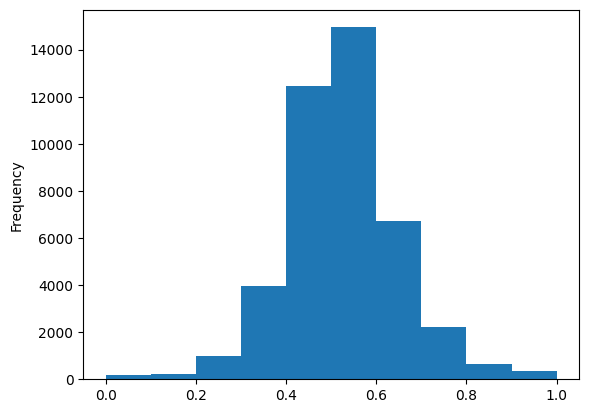

In [10]:
df["textblob_subjectivity"].plot.hist()

<AxesSubplot:ylabel='Frequency'>

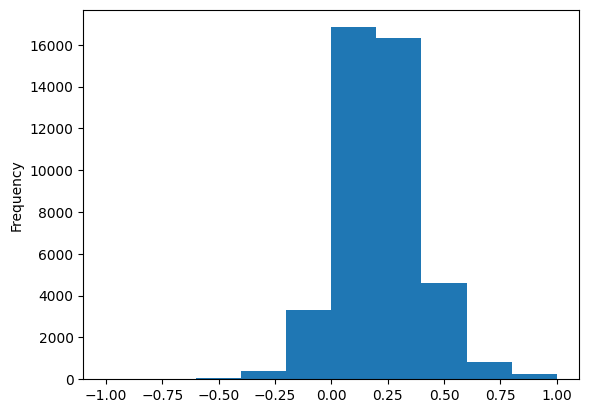

In [11]:
df["textblob_polarity"].plot.hist()

In [12]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

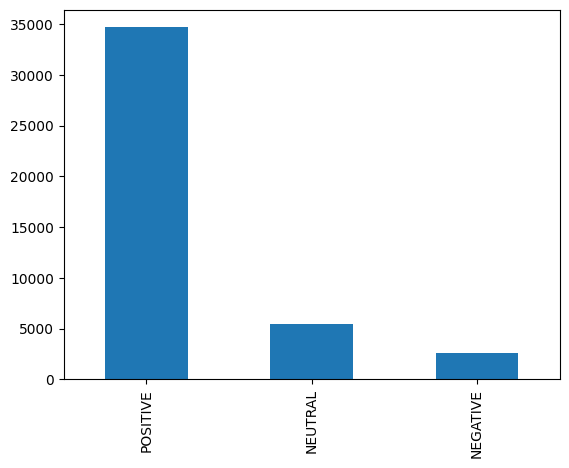

In [13]:
vs = []

for sentence in df["Review_Text"]:
    vs.append(analyzer.polarity_scores(sentence))

df["vs_score"] = vs
df['compound'] = df['vs_score'].apply(lambda score_dict: score_dict['compound'])

# Define custom thresholds
positive_threshold = 0.5
negative_threshold = -0.5

# Assign sentiment types based on custom thresholds
df['vs_sentiment_type'] = ''
df.loc[df.compound > positive_threshold, 'vs_sentiment_type'] = 'POSITIVE'
df.loc[(df.compound >= negative_threshold) & (df.compound <= positive_threshold), 'vs_sentiment_type'] = 'NEUTRAL'
df.loc[df.compound < negative_threshold, 'vs_sentiment_type'] = 'NEGATIVE'

df['vs_sentiment_type'].value_counts().plot.bar()
plt.show()


In [14]:
df['vs_sentiment_type'].value_counts()

POSITIVE    34680
NEUTRAL      5409
NEGATIVE     2567
Name: vs_sentiment_type, dtype: int64

In [15]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

In [16]:
# Load the dataset and drop rows with missing ratings
reviews = pd.read_csv("DisneylandReviews.csv", encoding='latin1')
reviews = reviews.dropna(subset=['Rating'])

In [17]:
# Function to classify reviews based on rating
def classify_review(rating):
    if rating >= 4:
        return "Positive"
    elif rating == 3:
        return "Neutral"
    else:
        return "Negative"

In [22]:
reviews['Actual_Sentiment'] = reviews['Rating'].apply(classify_review)

In [24]:
reviews['compound'] = reviews['Review_Text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [25]:
# Obtain TextBlob polarity scores
reviews['textblob_polarity'] = reviews['Review_Text'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [26]:
# Create a new DataFrame with actual sentiment, VADER compound score, and TextBlob polarity score
data = reviews[['Actual_Sentiment', 'compound', 'textblob_polarity']]

In [30]:
# Assuming 'reviews' is a DataFrame with 'compound', 'textblob_polarity' as features, and 'Actual_Sentiment' as the target
data = reviews[['Actual_Sentiment', 'compound', 'textblob_polarity']]
X = data[['compound', 'textblob_polarity']]
y = data['Actual_Sentiment']

In [31]:
# Split your data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Apply SMOTE to balance the classes in the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [33]:
# Train the logistic regression model on the resampled training data
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000)

In [34]:
# Evaluate the model on the testing set
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.34      0.56      0.42       720
     Neutral       0.20      0.35      0.26      1035
    Positive       0.92      0.75      0.82      6777

    accuracy                           0.68      8532
   macro avg       0.49      0.55      0.50      8532
weighted avg       0.78      0.68      0.72      8532



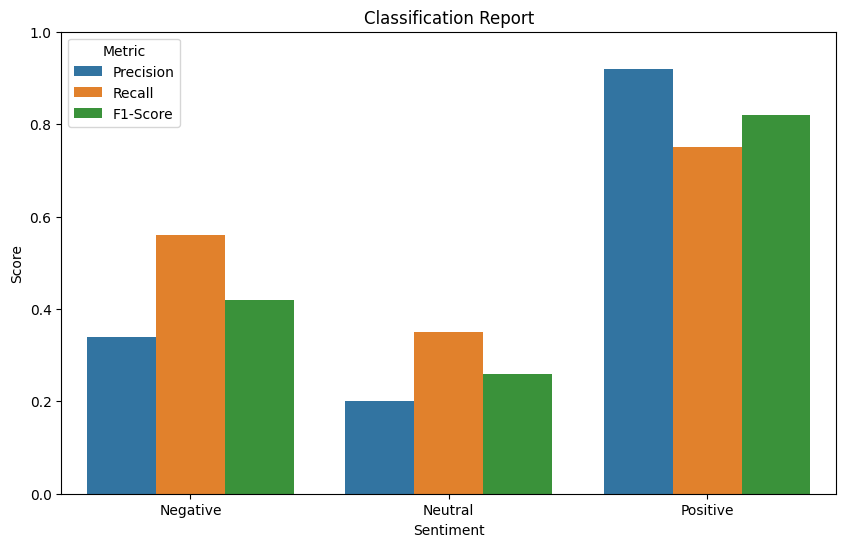

In [35]:
# Create a DataFrame with the classification report's output
report_data = [
    {'Sentiment': 'Negative', 'Precision': 0.34, 'Recall': 0.56, 'F1-Score': 0.42},
    {'Sentiment': 'Neutral', 'Precision': 0.20, 'Recall': 0.35, 'F1-Score': 0.26},
    {'Sentiment': 'Positive', 'Precision': 0.92, 'Recall': 0.75, 'F1-Score': 0.82}
]

report_df = pd.DataFrame(report_data)

# Melt the DataFrame to create a long-form DataFrame suitable for plotting
melted_report_df = report_df.melt(id_vars='Sentiment', var_name='Metric', value_name='Score')

# Create a bar plot for precision, recall, and F1-score for each class
plt.figure(figsize=(10, 6))
sns.barplot(x='Sentiment', y='Score', hue='Metric', data=melted_report_df)
plt.title('Classification Report')
plt.ylim(0, 1)
plt.show()